This notebook goes over how to plot the GHI output from single OptWRF model realizations for both WRF and ERA5

Last Updated Oct 7, 2020

In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf
from optwrf import plots

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


## Plotting functions start here -----------------------------------------------------------------------

In [2]:
def compare_wrf_era5_plot(var, wrfdat, eradat, hourly=False, save_fig=False, fig_path='./'):
    """
    Creates a side-by-side comparison plot of WRF and ERA5 producing either a plot every hour
    or a single plot for the day.
    """
    # Format the var input
    if type(var) is not str:
        print(f'The var input, {var}, must be a string.')
        raise TypeError
    if var in ['GHI', 'ghi']:
        var = 'ghi'
        wrf_var = 'ghi'
        era_var = 'GHI'
    elif var in ['WPD', 'wpd']:
        var = 'wpd'
        wrf_var = 'wpd'
        era_var = 'WPD'
    else:
        print(f'Variable {var} is not supported.')
        raise KeyError
        
    # Rename the lat-lon corrdinates to get wrf-python to recognize them
    variables = {'lat': 'XLAT',
                 'lon': 'XLONG'}
    try:
        wrfdat = xr.Dataset.rename(wrfdat, variables)
    except ValueError:
        print(f'Variables {variables} cannot be renamed, ' 
              f'those on the left are not in this dataset.')
    
    # This makes it easy to get the latitude and longitude coordinates with the wrf-python function below
    lats, lons = latlon_coords(wrfdat[wrf_var])
    
    # I have to do this tedious string parsing below to get the projection from the processed wrfout file.
    try:
        wrf_proj_params = wrfdat.dni.attrs['projection']
    except AttributeError:
        raise ValueError('Variable does not contain projection information')
    wrf_proj_params = wrf_proj_params.replace('(', ', ')
    wrf_proj_params = wrf_proj_params.replace(')', '')
    wrf_proj_params = wrf_proj_params.split(',')
    wrf_proj = wrf_proj_params[0]
    stand_lon = float(wrf_proj_params[1].split('=')[1])
    moad_cen_lat = float(wrf_proj_params[2].split('=')[1])
    truelat1 = float(wrf_proj_params[3].split('=')[1])
    truelat2 = float(wrf_proj_params[4].split('=')[1])
    pole_lat = float(wrf_proj_params[5].split('=')[1])
    pole_lon = float(wrf_proj_params[6].split('=')[1])
    
    # Fortunately, it still apppears to work.
    if wrf_proj == 'LambertConformal':
        wrf_cartopy_proj = ccrs.LambertConformal(central_longitude=stand_lon,
                                                 central_latitude=moad_cen_lat,
                                                 standard_parallels=[truelat1, truelat2])
    else: 
        print('Your WRF projection is not the expected Lambert Conformal.')
        raise ValueError
        
    # We can use a basic Plate Carree projection for ERA5
    era5_cartopy_proj = ccrs.PlateCarree()
    
    # Now, get the desired variables
    # Define the time indicies from the times variable
    time_indicies = range(0, len(wrfdat.Time))
    # Format the times for title slides
    times_strings_f = wrfdat.Time.dt.strftime('%b %d, %Y %H:%M')
    # Get the desired variable(s)
    for tidx in time_indicies:
        timestr = wrfdat.Time[tidx].values
        timestr_f = times_strings_f[tidx].values
        if hourly:
            title_str = f'{era_var} (kW m-2)\n{timestr_f} (UTC)'
        else:
            time_string_f = wrfdat.Time[0].dt.strftime('%b %d, %Y')
            title_str = f'{era_var} (kWh m-2 day-1) \n{time_string_f.values}'
        
        # WRF Variable (divide by 1000 to convert from W to kW or Wh to kWh)
        if not hourly and tidx != 0:
            plot_wrfvar = plot_wrfvar + (wrfdat[wrf_var].sel(Time=np.datetime_as_string(timestr)) / 1000)    
        else:
            plot_wrfvar = wrfdat[wrf_var].sel(Time=np.datetime_as_string(timestr)) / 1000
            
        # ERA5 GHI (divide by 1000 to convert from W to kW or Wh to kWh)
        if not hourly and tidx != 0:
            plot_era5var = plot_era5var + (eradat[era_var].sel(Time=timestr_f) / 1000)
        else:
            plot_era5var = eradat[era_var].sel(Time=timestr_f) / 1000
    
    # Create a figure
    fig = plt.figure(figsize=(6.5,2.4))
    
    # Set the GeoAxes to the projection used by WRF
    ax_wrf = fig.add_subplot(1,2,1, projection=wrf_cartopy_proj)
    ax_era5 = fig.add_subplot(1,2,2, projection=wrf_cartopy_proj, sharey=ax_wrf)

    # Get, format, and set the map bounds
    # I need to manually convert the boundaries of the WRF domain into Plate Carree to set the limits.
    # Get the raw map bounds using a wrf-python utility
    raw_bounds = wrf.util.geo_bounds(wrfdat[wrf_var])
    # Get the projected bounds telling cartopy that the input coordinates are lat/lon (Plate Carree)
    proj_bounds = wrf_cartopy_proj.transform_points(ccrs.PlateCarree(), 
                                                    np.array([raw_bounds.bottom_left.lon, raw_bounds.top_right.lon]), 
                                                    np.array([raw_bounds.bottom_left.lat, raw_bounds.top_right.lat]))
    # Format the projected bounds so they can be used in the xlim and ylim attributes
    proj_xbounds = [proj_bounds[0,0], proj_bounds[1,0]]
    proj_ybounds = [proj_bounds[0,1], proj_bounds[1,1]]
    # Finally, set the x and y limits
    ax_wrf.set_xlim(proj_xbounds)
    ax_wrf.set_ylim(proj_ybounds)
    ax_era5.set_xlim(proj_xbounds)
    ax_era5.set_ylim(proj_ybounds)

    # Download and add the states, coastlines, and lakes
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")

    # Add features to the maps
    ax_wrf.add_feature(states, linewidth=.5, edgecolor="black")
    ax_wrf.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
    ax_wrf.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax_era5.add_feature(states, linewidth=.5, edgecolor="black")
    ax_era5.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
    ax_era5.add_feature(cfeature.OCEAN.with_scale('50m'))

    # Make the countour lines for filled contours for the GHI
    if hourly:
        if var == 'ghi':
            contour_levels = np.linspace(0, 0.75, 22)
        elif var == 'wpd':
            contour_levels = np.linspace(0, 10000, 22)
    else:
        if var == 'ghi':
            contour_levels = np.linspace(0, 5, 22)
        elif var == 'wpd':
            contour_levels = np.linspace(0, np.amax(to_np(plot_wrfvar)), 22)

    # Add the filled contour levels
    if var == 'ghi':
        color_map = get_cmap("hot_r")
    elif var == 'wpd':
        color_map = get_cmap("Greens")
    wrf_cn = ax_wrf.contourf(to_np(lons), to_np(lats), to_np(plot_wrfvar), 
                             contour_levels, transform=ccrs.PlateCarree(), cmap=color_map)
    era5_cn = ax_era5.contourf(to_np(eradat.longitude), to_np(eradat.latitude), to_np(plot_era5var), 
                               contour_levels, transform=era5_cartopy_proj, cmap=color_map)

    # Add a color bar
    plt.colorbar(era5_cn, ax=ax_era5, shrink=.98)

    # Add the axis title
    ax_wrf.set_title('WRF ' + title_str)
    ax_era5.set_title('ERA5 ' + title_str)
    
    # Save the figure(s)
    if save_fig:
        if hourly:
            plt.savefig(fig_path + '.png', dpi=300, transparent=True, bbox_inches='tight')
        else:
            plt.savefig(fig_path + '.pdf', transparent=True, bbox_inches='tight')
    plt.show()

## -----------------------------------------------------------------------------------------------------

In [3]:
# Verbose setting
verbose = True

# Define the datestr and paramstr
datestr = '2011-12-13'
paramstr = '19mp4lw4sw7lsm8pbl99cu'
wrffile_name = f'wrfout_processed_d01_{datestr}_{paramstr}.nc'
wrffile_name_orig = f'wrfout_d01_{datestr}_{paramstr}.nc'

# Find the absolute file path to your optwrf package
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))
optwrf_abspath

# Open the original wrfout data (to use wrf-python I need the format from here)
wrffile_orig = os.path.join(optwrf_abspath, 'data', wrffile_name_orig)
wrfdata_orig = netCDF4.Dataset(wrffile_orig)
if verbose:
    print(f'Original WRF DATA:\n{wrfdata_orig}\n')

# Open the processed wrfout data
wrffile = os.path.join(optwrf_abspath, 'data', wrffile_name)
wrfdata = xr.open_dataset(wrffile)
if verbose:
    print(f'Processeed WRF DATA:\n{wrfdata}\n')
    
# Open the processed ERA5 data
erafile = os.path.join(optwrf_abspath, 'data', 'ERA5_EastUS_WPD-GHI_2011-12.nc')
eradata = xr.open_dataset(erafile)
if verbose:
    print(f'ERA5 DATA:\n{eradata}')

Original WRF DATA:
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE: 2011-12-13_00:00:00
    SIMULATION_START_DATE: 2011-12-13_00:00:00
    WEST-EAST_GRID_DIMENSION: 192
    SOUTH-NORTH_GRID_DIMENSION: 192
    BOTTOM-TOP_GRID_DIMENSION: 36
    DX: 12000.0
    DY: 12000.0
    AERCU_OPT: 0
    AERCU_FCT: 1.0
    IDEAL_CASE: 0
    DIFF_6TH_SLOPEOPT: 0
    AUTO_LEVELS_OPT: 2
    DIFF_6TH_THRESH: 0.1
    DZBOT: 50.0
    DZSTRETCH_S: 1.3
    DZSTRETCH_U: 1.1
    SKEBS_ON: 0
    SPEC_BDY_FINAL_MU: 1
    USE_Q_DIABATIC: 0
    GRIDTYPE: C
    DIFF_OPT: 1
    KM_OPT: 4
    DAMP_OPT: 0
    DAMPCOEF: 0.2
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 19
    RA_LW_PHYSICS: 4
    RA_SW_PHYSICS: 4
    SF_SFCLAY_PHYSICS: 1
    SF_SURFACE_PHYSICS: 7
    BL_PBL_PHYSICS: 8
    CU_PHYSICS: 99
    SF_LAKE_PHYSICS: 0
    SURFACE_INPUT_SOURCE: 1
    SST_UPDATE: 0
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 

The file name is: bilinear_191x191_97x129.nc and reuse_weights is: False


/Users/swardy9230/opt/anaconda3/envs/optwrf/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<xarray.Dataset>
Dimensions:          (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, west_east: 191)
Coordinates:
  * Time             (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
  * lon              (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat              (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times            (Time) datetime64[ns] ...
    temp_air         (Time, south_north, west_east) float32 ...
    wind_speed_u     (Time, south_north, west_east) float32 ...
    wind_speed_v     (Time, south_north, west_east) float32 ...
    cloud_fraction   (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith       (Time, south_north, west_east) float32 ...
    dni              (Time, south_north, west_east) float32 ...
    dhi              (Time, south_north, west_east) float32 ...
    ghi              (Time, south_north, we

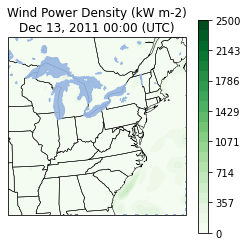

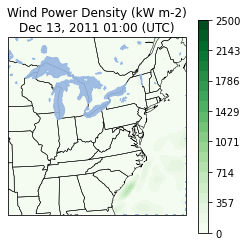

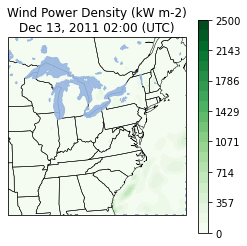

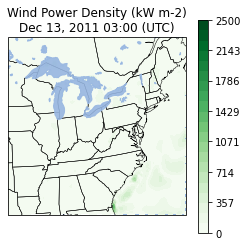

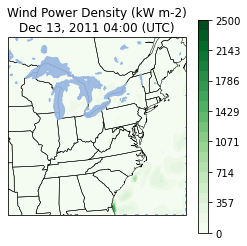

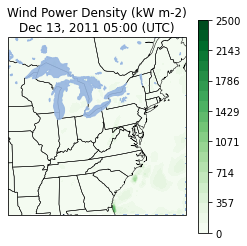

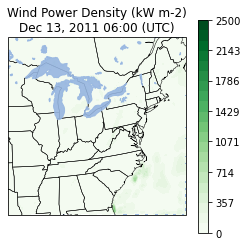

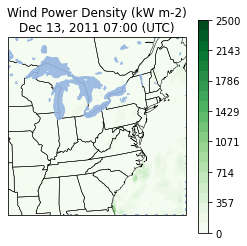

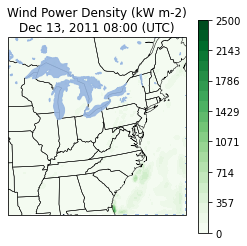

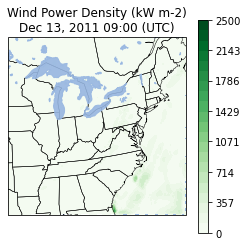

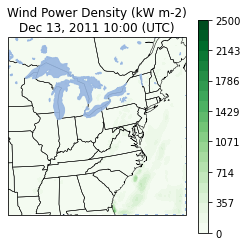

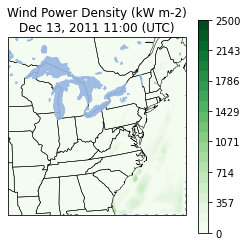

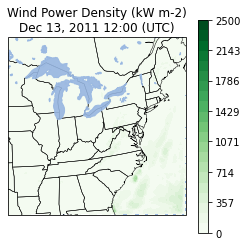

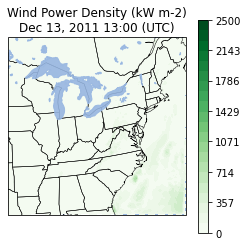

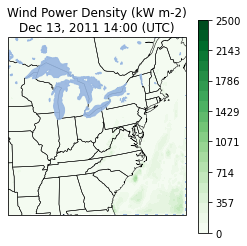

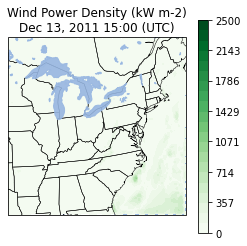

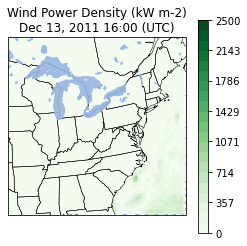

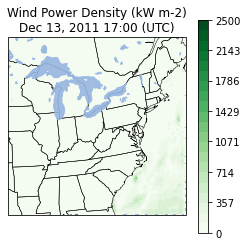

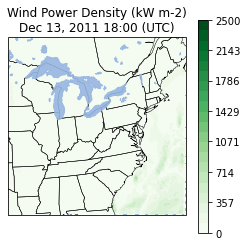

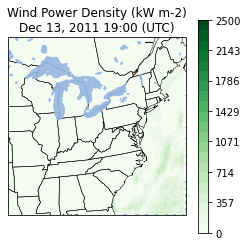

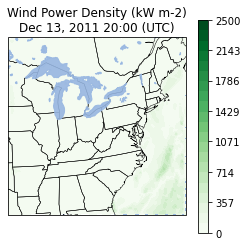

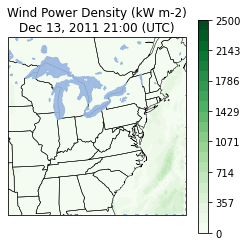

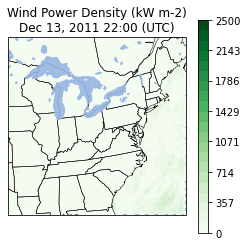

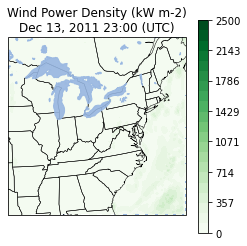

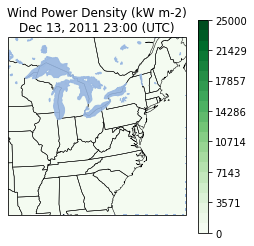

In [6]:
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/hourly_WRF_WPDerror_plot_{datestr}_{paramstr}'
plots.wrf_era5_plot('wpd_error', wrfdata, eradata, datestr, src='wrf', hourly=True, save_fig=True,
                    wrf_dir=os.path.join(optwrf_abspath, 'data/'), 
                    era_dir=os.path.join(optwrf_abspath, 'data/'), short_title_str='Wind Power Density (kW m-2)', fig_path=fig_path)

In [ ]:
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/daily_WRF_ERA5_GHI_compare_plot_{datestr}_{paramstr}'
compare_wrf_era5_plot('ghi', wrfdata, eradata, hourly=False, save_fig=True, fig_path=fig_path)

In [ ]:
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/daily_WRF_ERA5_WPD_compare_plot_{datestr}_{paramstr}'
compare_wrf_era5_plot('wpd', wrfdata, eradata, hourly=False, save_fig=True, fig_path=fig_path)

## Manual plotting (function dev) starts here ----------------------------------------------------------

In [ ]:
# Rename the lat-lon corrdinates to get wrf-python to recognize them
variables = {
             'lat': 'XLAT',
             'lon': 'XLONG',
            }
try:
    wrfdata = xr.Dataset.rename(wrfdata, variables)
except ValueError:
    print(f'Variables {variables} cannot be renamed, ' 
          f'those on the left are not in this dataset.')
wrfdata

In [ ]:
# This makes it easy to get the latitude and longitude coordinates with the wrf-python function below
lats, lons = latlon_coords(wrfdata.ghi)

In [ ]:
# I have to do this tedious string parsing below to get the projection from the processed wrfout file.
try:
    wrf_proj_params = wrfdata.dni.attrs['projection']
except AttributeError:
    raise ValueError("Variable does not contain projection information")
wrf_proj_params = wrf_proj_params.replace('(', ', ')
wrf_proj_params = wrf_proj_params.replace(')', '')
wrf_proj_params = wrf_proj_params.split(',')
print(wrf_proj_params)
wrf_proj = wrf_proj_params[0]
stand_lon = float(wrf_proj_params[1].split('=')[1])
moad_cen_lat = float(wrf_proj_params[2].split('=')[1])
truelat1 = float(wrf_proj_params[3].split('=')[1])
truelat2 = float(wrf_proj_params[4].split('=')[1])
pole_lat = float(wrf_proj_params[5].split('=')[1])
pole_lon = float(wrf_proj_params[6].split('=')[1])

In [ ]:
# Fortunately, it still apppears to work.
if wrf_proj == 'LambertConformal':
    wrf_cartopy_proj = ccrs.LambertConformal(
                                            central_longitude=stand_lon,
                                            central_latitude=moad_cen_lat,
#                                             standard_parallels=[truelat1, truelat2],
                                            )
else: 
    print('Check yourself...')
wrf_cartopy_proj

In [ ]:
vars(wrf_cartopy_proj)

In [ ]:
# We can simply use a Plate Carree projection for ERA5
era5_cartopy_proj = ccrs.PlateCarree()
era5_cartopy_proj

In [ ]:
# Format the times for title slides
times_strings_f = wrfdata.Time.dt.strftime('%b %d, %Y %H:%M')

In [ ]:
# Define the time indicies from the times variable
time_indicies = range(0, len(wrfdata.Time))
# Format the times for title slides
times_strings_f = wrfdata.Time.dt.strftime('%b %d, %Y %H:%M')
# Get the desired variable(s)
hourly=True
timestr = wrfdata.Time[15].values
timestr_f = times_strings_f[15].values
if hourly:
    title_str = f'GHI (kW m-2)\n{timestr_f} (UTC)'
else:
    time_string_f = wrfdata.Time[0].dt.strftime('%b %d, %Y')
    title_str = f'GHI (kWh m-2 day-1) \n{time_string_f.values}'

# WRF GHI
if not hourly and 15 != 0:
    wrfghi = wrfghi + (wrfdata.ghi.sel(Time=np.datetime_as_string(timestr)) / 1000)
else:
    wrfghi = wrfdata.ghi.sel(Time=np.datetime_as_string(timestr)) / 1000

In [ ]:
# ERA5 GHI
if not hourly and 15 != 0:
    era5ghi = era5ghi + (eradata.GHI.sel(Time=timestr_f) / 1000)
else:
    era5ghi = eradata.GHI.sel(Time=timestr_f) / 1000

In [ ]:
dni_orig = getvar(wrfdata_orig, "SWDDNI", timeidx=15)
# # Get the cartopy mapping object
# wrf_cartopy_proj = get_cartopy(dni_orig)

In [ ]:
cartopy_ylim(dni_orig)

In [ ]:
cartopy_xlim(dni_orig)

In [ ]:
# I need to manually convert the boundaries of the WRF domain into Plate Carree to set the extent of the domain.
# Note that the projected X and Y boundaries almost* match those given by the cartopy_xlim and cartopy_ylim above
raw_bounds = wrf.util.geo_bounds(wrfdata.ghi)
# geo_bounds = GeoBounds(CoordPair(lat=np.amin(to_np(lats)), lon=-85.0),
#                        CoordPair(lat=30.0, lon=-72.0))
print('Raw Latitude Boundaries')
print(f'Bottom Left: {raw_bounds.bottom_left.lon}, {raw_bounds.bottom_left.lat}')
print(f'Top Right: {raw_bounds.top_right.lon}, {raw_bounds.top_right.lat}')
proj_bounds = wrf_cartopy_proj.transform_points(ccrs.PlateCarree(), np.array([raw_bounds.bottom_left.lon,
                              raw_bounds.top_right.lon]),
                     np.array([raw_bounds.bottom_left.lat,
                               raw_bounds.top_right.lat]))
proj_xbounds = [proj_bounds[0,0], proj_bounds[1,0]]
proj_ybounds = [proj_bounds[0,1], proj_bounds[1,1]]
print('\nProjectecd Boundaries')
print(proj_bounds)
print('\nX and Y Boundaries')
print(f'XLIM: {proj_xbounds}')
print(f'YLIM: {proj_ybounds}')

In [ ]:
# Create a figure
fig = plt.figure(figsize=(6.5,2.4))
# Set the GeoAxes to the projection used by WRF
# ax = plt.axes(projection=wrf_cartopy_proj)
ax_wrf = fig.add_subplot(1,2,1, projection=wrf_cartopy_proj)
ax_era5 = fig.add_subplot(1,2,2, projection=wrf_cartopy_proj, sharey=ax_wrf)

# Set the map bounds
ax_wrf.set_xlim(proj_xbounds)
ax_wrf.set_ylim(proj_ybounds)
ax_era5.set_xlim(proj_xbounds)
ax_era5.set_ylim(proj_ybounds)

# Download and add the states, coastlines, and lakes
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")

# Add features to the maps
ax_wrf.add_feature(states, linewidth=.5, edgecolor="black")
ax_wrf.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax_wrf.add_feature(cfeature.OCEAN.with_scale('50m'))
ax_era5.add_feature(states, linewidth=.5, edgecolor="black")
ax_era5.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax_era5.add_feature(cfeature.OCEAN.with_scale('50m'))

# Make the countour lines for filled contours for the GHI
if hourly:
    contour_levels = np.linspace(0, 0.75, 22)
else:
    contour_levels = np.linspace(0, 5, 22)
    
# Add the filled contour levels
wrf_cn = ax_wrf.contourf(to_np(lons), to_np(lats), to_np(wrfghi), 
                         contour_levels, transform=ccrs.PlateCarree(), cmap=get_cmap("hot_r"))
era5_cn = ax_era5.contourf(to_np(eradata.longitude), to_np(eradata.latitude), to_np(era5ghi), 
                           contour_levels, transform=era5_cartopy_proj, cmap=get_cmap("hot_r"))

# Add a color bar
plt.colorbar(era5_cn, ax=ax_era5, shrink=.98)

# Add the axis title
ax_wrf.set_title('WRF ' + title_str)
ax_era5.set_title('ERA5 ' + title_str)
plt.show()

In [ ]:
np.amax(to_np(wrfdata['wpd']))

In [ ]:
# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax_wrf = plt.axes(projection=wrf_cartopy_proj)

# Set the map bounds
ax_wrf.set_xlim(cartopy_xlim(dni_orig))
ax_wrf.set_ylim(cartopy_ylim(dni_orig))

# Download and add the states, coastlines, and lakes
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax_wrf.add_feature(states, linewidth=.5, edgecolor="black")
ax_wrf.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
ax_wrf.add_feature(cfeature.OCEAN.with_scale('50m'))

# Make the countour lines for filled contours for the GHI
if hourly:
    contour_levels = np.linspace(0, 0.75, 22)
else:
    contour_levels = np.linspace(0, 5, 22)
plt.contourf(to_np(eradata.longitude), to_np(eradata.latitude), to_np(era5ghi), 
                  contour_levels,
                  transform=ccrs.PlateCarree(),
                  cmap=get_cmap("hot_r"))

# Add a color bar
plt.colorbar(ax=ax_wrf, shrink=.98)

# Add the axis title
plt.title(title_str)
plt.show()

## OLD Plotting functions start here --------------------------------------------------------------------

In [ ]:
def create_plot(cart_proj, plot_var, fmt_var, lats, lons, title_str='', hourly= False, save_fig=False, fig_path='./plot'):
    # Create a figure
    fig = plt.figure(figsize=(12,6))
    # Set the GeoAxes to the projection used by WRF
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Make the countour lines for filled contours for the GHI
    if hourly:
        contour_levels = np.linspace(0, 0.75, 22)
    else:
        contour_levels = np.linspace(0, 5, 22)
    plt.contourf(to_np(lons), to_np(lats), to_np(plot_var), contour_levels,
                 transform=cart_proj,
                 cmap=get_cmap("hot_r"))

    # Format the plot
    format_plot(fmt_var, ax, title_str)

    # Save the figure(s)
    if save_fig:
        if hourly:
            plt.savefig(fig_path + '.png', dpi=300, transparent=True, bbox_inches='tight')
        else:
            plt.savefig(fig_path + '.pdf', transparent=True, bbox_inches='tight')

In [ ]:
def format_plot(lim_var, ax, title_str=''):
    
    # Download and add the states, coastlines, and lakes
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.5, edgecolor="black")
#     ax.coastlines(resolution='10m', linewidth=0.8)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.98)

    # Set the map bounds
    bounds = wrf.util.geo_bounds(lim_var)
    ax.set_xlim([bounds.bottom_left.lon, bounds.top_right.lon])
    ax.set_ylim([bounds.bottom_left.lat, bounds.top_right.lat])
#     ax.set_extent(wrf.util.geo_bounds(lim_var))

    # Add the gridlines
#     ax.gridlines(color="black", linestyle="dotted")
    
    # Add the axis title
    plt.title(title_str)

In [ ]:
def plot_daily_GHI(wrfdat, wrfdat_orig, hourly=False, save_fig=False, fig_path='./'):
    # Define the time indicies from the times variable
    time_indicies = range(0, len(wrfdat.Time))
    # Format the times for title slides
    times_strings_f = wrfdat.Time.dt.strftime('%b %d, %Y %H:%M')
    # Get the desired variable(s)
    for tidx in time_indicies:
        timestr = wrfdat.Time[tidx].values
        timestr_f = times_strings_f[tidx].values
        if hourly:
            title_str = f'Global Horizontal Irradiance (kW m-2)\n{timestr_f} (UTC)'
        else:
            time_string_f = wrfdat.Time[0].dt.strftime('%b %d, %Y')
            title_str = f'Global Horizontal Irradiance (kWh m-2 day-1) \n{time_string_f.values}'
        
        if not hourly and tidx != 0:
            dni = dni + wrfdat.dni.sel(Time=np.datetime_as_string(timestr))
            ghi = ghi + (wrfdat.ghi.sel(Time=np.datetime_as_string(timestr)) / 1000)
        else:
            dni = wrfdat.dni.sel(Time=np.datetime_as_string(timestr))
            ghi = wrfdat.ghi.sel(Time=np.datetime_as_string(timestr)) / 1000
            
        # Get a variable from the unprocessed WRF file so we can get lats, lons, and map projection.
        # Would have been nice to think about this before post-processing...
        dni_orig = getvar(wrfdat_orig, "SWDDNI", timeidx=tidx)
        
        # Get the latitude and longitude points
        lats, lons = latlon_coords(dni_orig)

        # Get the cartopy mapping object
        try:
            wrf_proj = wrfdat.dni.attrs['projection']
        except AttributeError:
            raise ValueError("Variable does not contain projection information")
        
        if hourly:
            fig_path_temp = fig_path + str(tidx).zfill(2)
            create_plot(wrf_proj, ghi, dni_orig, lats, lons, title_str, hourly, save_fig, fig_path_temp)
    if not hourly:
        create_plot(wrf_proj, ghi, dni_orig, lats, lons, title_str, hourly, save_fig, fig_path)